<a href="https://colab.research.google.com/github/LetsTrie/COVID-19-BD-Data/blob/master/test_rates/TestRateClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import argrelextrema
from sklearn.linear_model import Ridge
from sklearn.neighbors.kde import KernelDensity
from pandas import DataFrame
from numpy import *
import copy
import json, io
import sys
import math
import random
from copy import deepcopy
from sklearn.cluster import KMeans

In [60]:
main_data = pd.read_csv('modified_data.csv')
main_data_frame = main_data.copy()
main_data_frame = main_data_frame.values
bd_data = main_data_frame[4]

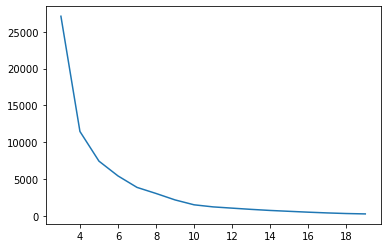

In [61]:
def form_param_array(param_no):
  dataset = []
  for i in range(len(main_data_frame)):
     dataset.append((main_data_frame[i][param_no], 0))
  
  return dataset

def form_single_param_array(param_no):
  dataset = []
  for i in range(len(main_data_frame)):
     dataset.append(main_data_frame[i][param_no])
  
  return dataset

def form_dataset_2(param_no):
  dataset = []
  def comp(x):
    return abs(x[param_no] - bd_data[param_no])
    
  country_data.sort(key=comp)

  for i in range(1, size+1):
    dataset.append([country_data[i][param_no], country_data[i][6]])

  return dataset

def test_cluster_size(param_no, a=3, b=20):
  data = form_param_array(param_no)
  y = []
  x = range(a,b)
  for i in range(a, b):
    model = KMeans(n_clusters=i)
    data = np.array(form_param_array(param_no))
    model.fit(data)
    y.append(model.inertia_)
  plt.plot(x, y)
  plt.show()
    
test_cluster_size(7)
cluster_sizes = [0, 0, 0, 6, 5, 6, 5, 4]

def refine(cluster, param_no):
  _cluster = []
  for value in cluster:
    test_rate = next(x for x in main_data_frame if x[param_no] == value[0])[2]
    _cluster.append([value[0], test_rate])
  return _cluster

def form_dataset_kmeans(param_no, k=5):
  param_array = form_param_array(param_no)
  model = KMeans(n_clusters=k)
  model.fit(param_array)
  clusters = []

  for i in range(len(model.labels_)):
    clusters.append([])
  for i in range(len(model.labels_)):
    clusters[model.labels_[i]].append(param_array[i])
  for cluster in clusters:
    if (bd_data[param_no], 0) in cluster:
      return refine(cluster, param_no)

def weighted_mean(data, bd_data):
  weights = []
  avg = 0

  if len(data) == 0 or np.isnan(data).any():
    return 0

  for i in range(len(data)):
    weight = 1
    if bd_data - data[i][0] != 0:
      weight = 1 / abs(bd_data - data[i][0])
    weights.append(weight)
  _max = np.max(weights)
  norm_weights = list(map(lambda x: x/_max, weights)) 
  for i in range(len(data)):
    avg += (data[i][1]*norm_weights[i])
  avg = avg / np.sum(norm_weights)

  return avg


def find_cor(set1, set2):
  mean1 = np.mean(set1)
  mean2 = np.mean(set2)
  numer = 0
  denom = 0

  for i in range(len(set1)):
    numer += (set1[i] - mean1) * (set2[i] - mean2)
    denom += pow(set1[i] - mean1, 2) * pow(set2[i] - mean2, 2)
  denom = math.sqrt(denom)

  return abs(numer / denom)

In [66]:
bd_avg_test_rate = bd_data[2]

FROM_GDP_INDEX = 3
UPTO_END_INDEX = 8
TEST_RATE_COLUMN = 2

def compute():
  param_weight_sum = 0
  test_rate = 0

  for i in range(FROM_GDP_INDEX, UPTO_END_INDEX):
    dataset = form_dataset_kmeans(i, cluster_sizes[i])
    print(i, len(dataset))
    avg = weighted_mean(dataset, bd_data[i])
    print(f"Test rate per parameter: {avg}")
    weight = find_cor(form_single_param_array(i), form_single_param_array(TEST_RATE_COLUMN))
    test_rate += (weight * avg)
    param_weight_sum += weight

  test_rate = test_rate / param_weight_sum
  return (test_rate, test_rate / bd_avg_test_rate)

In [67]:
res = compute()
print(res)
print(f"BD average test per million: {bd_avg_test_rate}")

3 26
Test rate per parameter: 64.19396269504493
4 7
Test rate per parameter: 62.921256207094764
5 2
Test rate per parameter: 80.03716765253867
6 35
Test rate per parameter: 197.66993115103662
7 32
Test rate per parameter: 235.10145372502507
(132.17773494853836, 2.1006884799234973)
BD average test per million: 62.92115
